<a href="https://colab.research.google.com/github/ganjire/ML2_Project/blob/main/ML2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Idea: Automated Disease Detection in Plant Leaves using Convolutional Neural Networks (CNNs)**

**Project Goal/Motivation**

The goal of this project is to develop an automated system that can identify and classify plant diseases from images of plant leaves. This is crucial for agricultural technology as early detection of diseases can lead to timely intervention, reducing both the spread of disease and economic losses. This project will help in understanding the practical application of CNNs in a real-world problem, exploring various architectures, and utilizing transfer learning for effective model performance on a specialized task.

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
import os
import tensorflow as tf
import keras
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


#**Data Collection and Preparation**

In [2]:
# Download PlantVillage-Dataset from Kaggle
directory_root = drive.mount('/content/drive')
dataset_root = '/content/drive/My Drive/PlantVillage'

Mounted at /content/drive


In [3]:
import os

data_path = '/content/drive/My Drive/PlantVillage'  # Path to Folder

# Right Path to Main Folder
categories = os.listdir(data_path)
print("Categories (Classes):", categories)

# Number of Images in Subfolders
for category in categories:
    category_path = os.path.join(data_path, category)
    num_images = len(os.listdir(category_path))
    print(f"{category}: {num_images} images")


Categories (Classes): ['Tomato__Target_Spot', 'Potato___Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy', 'Tomato__Tomato_mosaic_virus', 'Tomato_Early_blight', 'Potato___Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Bacterial_spot', 'Pepper__bell___Bacterial_spot', 'Tomato_Late_blight', 'Potato___healthy', 'Pepper__bell___healthy']
Tomato__Target_Spot: 703 images
Potato___Early_blight: 500 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 1605 images
Tomato_healthy: 799 images
Tomato__Tomato_mosaic_virus: 190 images
Tomato_Early_blight: 504 images
Potato___Late_blight: 500 images
Tomato_Leaf_Mold: 481 images
Tomato_Septoria_leaf_spot: 886 images
Tomato_Spider_mites_Two_spotted_spider_mite: 838 images
Tomato_Bacterial_spot: 1069 images
Pepper__bell___Bacterial_spot: 499 images
Tomato_Late_blight: 955 images
Potato___healthy: 76 images
Pepper__bell___healthy: 743 images


**Load images and labels from directory**

In [4]:
from PIL import Image
import numpy as np

def load_images_and_labels(data_directory):
    images = []
    labels = []
    categories = os.listdir(data_directory)

    for label, category in enumerate(categories):
        category_path = os.path.join(data_directory, category)
        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            try:
                with Image.open(image_path) as img:
                    img = img.resize((128, 128))
                    img = np.array(img)
                    if img.shape == (128, 128, 3):
                        images.append(img)
                        labels.append(label)
            except Exception as e:
                print(f"Can't load image {image_path}: {e}")

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(data_path)
print(f"Loaded Images: {len(images)}")
print(f"Loaded Images: {len(labels)}")


Can't load image /content/drive/My Drive/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c: cannot identify image file '/content/drive/My Drive/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c'
Loaded Images: 10347
Loaded Images: 10347


In [ ]:
unique_labels, counts = np.unique(labels, return_counts=True)
print("Unique labels (classes):", unique_labels)
print("Number of images per class:", counts)


Unique labels (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Number of images per class: [ 703  500 1604  799  190  504  500  481  886  838 1069  499  955   76
  743]


**Data splitting and one-hote encoding**

In [ ]:
# First Split: Split Training Data (70%) und rest (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels)

# Second Split: Split from Validation Data (20% of 100% -> 2/3 of 30%) and Test Data (10% of 100% -> 1/3 of 30%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=15)
y_valid_one_hot = to_categorical(y_valid, num_classes=15)
y_test_one_hot = to_categorical(y_test, num_classes=15)


**Data Augumentation and Visualization**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Konfiguration für den Trainingsgenerator mit Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Konfiguration für Validierungs- und Testgenerator ohne Data Augmentation, nur Rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Erstellen der Generatoren mit den One-Hot-encoded Labels
train_generator = train_datagen.flow(X_train, y_train_one_hot, batch_size=32)
validation_generator = validation_datagen.flow(X_valid, y_valid_one_hot, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test_one_hot, batch_size=32)


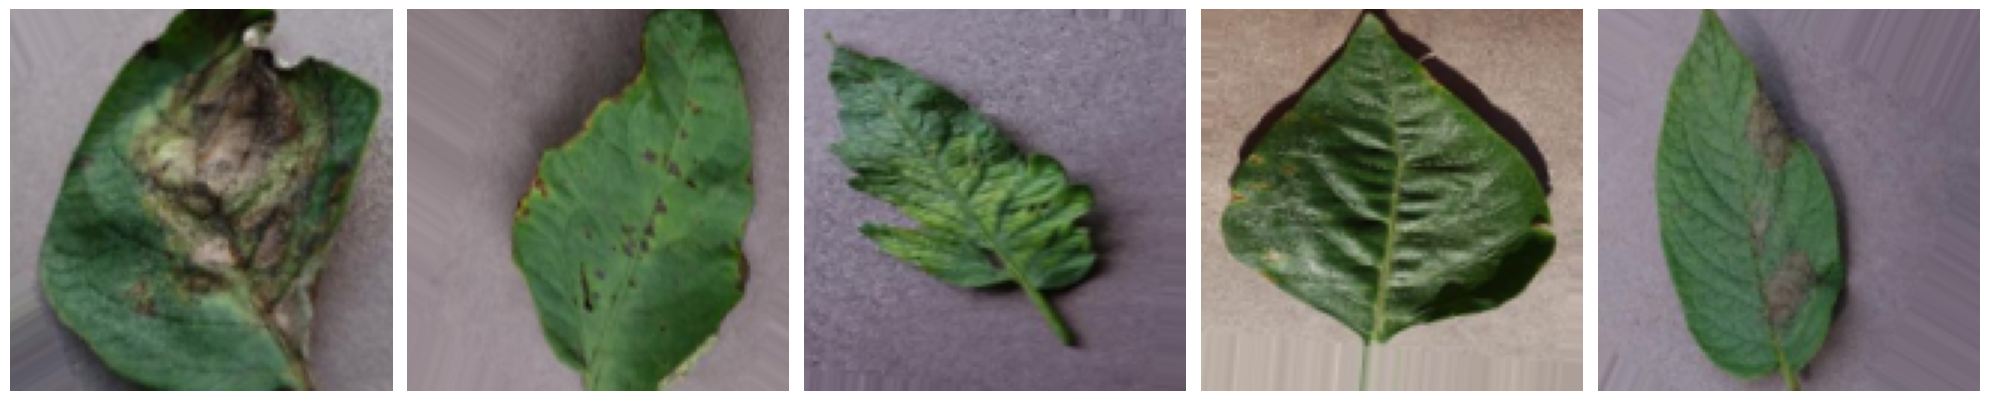

In [ ]:
# Wählen Sie eine kleine Stichprobe von Bildern für die Demonstration
X_sample = X_train[:5]

# Erstellen eines Generators für die ausgewählten Beispiele
sample_generator = train_datagen.flow(X_sample, batch_size=1)

# Sammeln der augmentierten Bilder
augmented_images = [sample_generator.next()[0] for _ in range(5)]  # 5 augmentierte Bilder generieren

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):

        # Da img durch rescale modifiziert wurde und matplotlib erwartet, dass die Daten im Bereich [0, 1] liegen,
        # ist keine weitere Anpassung der Bild-Daten notwendig.
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Aufrufen der Funktion mit den augmentierten Bildern
plot_images(augmented_images)


#**Data Modeling**

**Create 1st Model**





In [ ]:
# Define the CNN model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

# Compile the model
model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print model summary
model_cnn.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

**Create checkpoints and train and save final model**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define path for Checkpoints
checkpoint_path = '/content/drive/My Drive/Checkpoints/model_cnn_epoch{epoch:02d}-loss{val_loss:.2f}.h5'

# Create ModelCheckpoint Callbacks
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)


In [ ]:
history = model_cnn.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=13,
    validation_data=validation_generator,
    validation_steps=len(X_valid) // 32,
    callbacks=[checkpoint_callback]
)


Epoch 1/13
226/226 [==============================] - ETA: 0s - loss: 1.9645 - accuracy: 0.3687
Epoch 1: val_loss improved from inf to 1.19604, saving model to /content/drive/My Drive/Checkpoints/model_cnn_epoch01-loss1.20.h5
226/226 [==============================] - 304s 1s/step - loss: 1.9645 - accuracy: 0.3687 - val_loss: 1.1960 - val_accuracy: 0.6191
Epoch 2/13
226/226 [==============================] - ETA: 0s - loss: 1.2087 - accuracy: 0.6064
Epoch 2: val_loss improved from 1.19604 to 0.70698, saving model to /content/drive/My Drive/Checkpoints/model_cnn_epoch02-loss0.71.h5
226/226 [==============================] - 302s 1s/step - loss: 1.2087 - accuracy: 0.6064 - val_loss: 0.7070 - val_accuracy: 0.7588
Epoch 3/13
226/226 [==============================] - ETA: 0s - loss: 0.9317 - accuracy: 0.6899
Epoch 3: val_loss improved from 0.70698 to 0.57893, saving model to /content/drive/My Drive/Checkpoints/model_cnn_epoch03-loss0.58.h5
226/226 [==============================] - 310s 1s

In [ ]:
model_cnn.save('/content/drive/My Drive/model_cnn.h5')

**Create 2nd Model**

Different activation functions and dropout rates.

In [ ]:
model_cnn2 = Sequential([
    Conv2D(32, (3, 3), input_shape=(128, 128, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

# Compile the model
model_cnn2.compile(optimizer=RMSprop(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Print model summary
model_cnn2.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 61, 61, 64)        0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                

In [ ]:
history = model_cnn2.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(X_valid) // 32
)

Epoch 1/10
226/226 [==============================] - 317s 1s/step - loss: 2.4298 - accuracy: 0.2197 - val_loss: 1.9066 - val_accuracy: 0.3970
Epoch 2/10
226/226 [==============================] - 315s 1s/step - loss: 1.7047 - accuracy: 0.4660 - val_loss: 1.3826 - val_accuracy: 0.5239
Epoch 3/10
226/226 [==============================] - 334s 1s/step - loss: 1.2480 - accuracy: 0.5981 - val_loss: 0.9418 - val_accuracy: 0.6870
Epoch 4/10
226/226 [==============================] - 312s 1s/step - loss: 1.0086 - accuracy: 0.6741 - val_loss: 0.6335 - val_accuracy: 0.7944
Epoch 5/10
226/226 [==============================] - 315s 1s/step - loss: 0.8548 - accuracy: 0.7184 - val_loss: 0.5025 - val_accuracy: 0.8315
Epoch 6/10
226/226 [==============================] - 312s 1s/step - loss: 0.7411 - accuracy: 0.7549 - val_loss: 0.5369 - val_accuracy: 0.8145
Epoch 7/10
226/226 [==============================] - 306s 1s/step - loss: 0.6939 - accuracy: 0.7761 - val_loss: 0.5078 - val_accuracy: 0.8340

In [ ]:
model_cnn2.save('/content/drive/My Drive/model_cnn2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Evaluate Model**

In [ ]:
from tensorflow.keras.models import load_model

# Replace 'path_to_my_model.h5' with the actual path to your saved model file
model = load_model('/content/drive/My Drive/model_cnn.h5')
model2 = load_model('/content/drive/My Drive/model_cnn2.h5')


In [ ]:
# Evaluate model with test data from dataset
# Reminder: test_generator = test_datagen.flow(X_test, y_test_one_hot, batch_size=32)

model.evaluate(test_generator)
model2.evaluate(test_generator)


33/33 [==============================] - 12s 355ms/step - loss: 0.4636 - accuracy: 0.8609


[0.46356576681137085, 0.8608695864677429]

#**Evaluation**

**Save Test Images in separate file for testing the model**

In [ ]:
# IMPORTANT! Folder with images already created, do not run again. Use Link on GitHub

import os

# Pfad zum Zielordner
folder_path = '/content/drive/My Drive/TestImages'

# Erstellen des Ordners, falls er nicht existiert
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


In [ ]:
# IMPORTANT! Folder with images already created, do not run again. Use Link on GitHub

# Angenommen, Sie haben einen Generator `test_generator` für Ihre Testbilder

for i, (images, labels) in enumerate(test_generator):
    for j, image in enumerate(images):

        # Pfad, unter dem das Bild gespeichert werden soll
        image_path = os.path.join(folder_path, f'test_image_{i}_{j}.png')

        # Bild speichern
        save_img(image_path, image)

    # Optional: Stoppen Sie die Schleife nach dem ersten Batch, falls Sie nicht alle Bilder speichern wollen
    if i == 0:  # Entfernen oder anpassen dieser Zeile, um mehr Bilder zu speichern
        break


In [ ]:
# Update this path to your image's path
image_path = '/content/drive/My Drive/TestImages/test_image_0_31.png'

def preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image /= 255.0  # Rescale the image
    image = np.expand_dims(image, axis=0)  # Expand dimensions to fit model input
    return image

# Process the image
processed_image = preprocess_image(image_path)



In [ ]:
# Load the pre-trained model
model = load_model('/content/drive/My Drive/model_cnn.h5')  # Update with the path to your saved model

# Predict
predictions = model.predict(processed_image)
predicted_class = np.argmax(predictions, axis=1)
predicted_probability = np.max(predictions, axis=1)[0]

# Map the predicted class index to a class name, assuming you have a list of class names
#class_names = ['Disease1', 'Disease2', 'Hea]  # Update this list as per your classes
predicted_class_name = categories[predicted_class[0]]
print(f"Predicted class: {predicted_class_name}, Probability: {predicted_probability:.2f}")



1/1 [==============================] - 0s 97ms/step
Predicted class: Pepper__bell___Bacterial_spot, Probability: 0.90
